### Spectral Clustering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, davies_bouldin_score, calinski_harabasz_score
import utils

In [2]:
!pip install yellowbrick
!pip install utils

### Data loading 

- aquastat + ws + unicef

In [3]:
# rename year period to merge with water stress indicators
df = pd.read_csv('clean data/aqua_socec_clean.csv', index_col=0)
df.rename(columns = {'country':'Country' ,
                     '1998-2002':'2002', 
                     '2003-2007': '2007', 
                     '2008-2012': '2012',
                     '2013-2017':'2017'}, inplace = True)
df.sample(4)

,Country,variable,2002,2007,2012,2017
1899,SWE,Total population with access to safe drinking-...,100.000000,100.000000,100.000000,100.000000
1984,TON,Human Development Index (HDI) [highest = 1] (-),0.676000,0.678000,0.700000,0.717000
650,ETH,Urban population (1000 inhab),10657.558000,13054.220000,16787.864000,21316.856000
706,GAB,Population density (inhab/km2),4.813072,5.501457,6.536713,7.714062


In [4]:
df_ws = pd.read_csv('clean data/water_stress.csv',index_col=0)
df_ws.sample(5)

,Country,Water stress (MDG),Water use efficiency (SDG),Water stress (SDG)
9,AZE,36.861139,3.665472,56.443365
108,MLT,85.148515,164.743509,85.148515
23,BRN,1.082353,NaN,3.466466
92,LBN,40.239840,25.640121,58.792992
157,SYR,83.111534,0.980661,124.360139


In [5]:
# change type of var year to merge
df_ws["Year"] = "2017"
df_ws["Year"] = df_ws["Year"].astype("object")
df_ws["Year"].unique()
df_ws.sample(4)

,Country,Water stress (MDG),Water use efficiency (SDG),Water stress (SDG),Year
70,HRV,0.637820,58.968467,1.495998,2017
109,MMR,2.845607,1.772521,5.801501,2017
23,BRN,1.082353,NaN,3.466466,2017
21,BRA,0.759570,22.010528,3.105437,2017


In [6]:
df_unif = pd.read_csv('clean data/unicef_socec_clean.csv', index_col=0)
df_unif.sample(5)

,Indicator,Country,Time,Value
87545,GDP per capita (current US$),SWE,2018,5.458900e+04
92461,Price level ratio of PPP conversion factor (GD...,COL,2002,3.000000e-01
45358,"GNI per capita, Atlas method (current US$)",JOR,2002,1.800000e+03
42105,General government total expenditure (current ...,HTI,2007,3.967700e+10
90829,Price level ratio of PPP conversion factor (GD...,ETH,2012,4.000000e-01


In [7]:
# transform type indicators and slice length name
df["variable"] = df["variable"].astype("string")
df["variable"] = df['variable'].str.slice(0,35)
df['variable'].unique()

<StringArray>
[      'Rural population (1000 inhab)',       'Urban population (1000 inhab)',
      'Population density (inhab/km2)',  'GDP per capita (current US$/inhab)',
 'Human Development Index (HDI) [high', 'Total population with access to saf',
 'Rural population with access to saf', 'Urban population with access to saf']
Length: 8, dtype: string

In [8]:
# transform data aquastat long format (year as attribute)
df_melt = pd.melt(df, id_vars=["Country","variable"], 
        var_name="Year", 
        value_name="value")
df_melt.head(4)

,Country,variable,Year,value
0,AFG,Rural population (1000 inhab),2002,17086.910000
1,AFG,Urban population (1000 inhab),2002,4893.013000
2,AFG,Population density (inhab/km2),2002,34.618096
3,AFG,GDP per capita (current US$/inhab),2002,194.958382


In [9]:
# transform data aquastat wide format (indicators as attributes)
df_piv = df_melt.pivot_table(values='value', 
                             index=['Year','Country'], 
                             columns='variable',
                             fill_value=0)
df_piv = df_piv.reset_index()

In [10]:
df_unif.rename(columns = {'Time':"Year"}, inplace=True)

In [11]:
# merge aquastat with water stress. 
# left merge to only keep aquastat countries
df_piv_ws = pd.merge(df_piv, df_ws, on=["Country", "Year"], how='left')
df_piv_ws.sample(5)

,Year,Country,GDP per capita (current US$/inhab),Human Development Index (HDI) [high,Population density (inhab/km2),Rural population (1000 inhab),Rural population with access to saf,Total population with access to saf,Urban population (1000 inhab),Urban population with access to saf,Water stress (MDG),Water use efficiency (SDG),Water stress (SDG)
238,2007,NZL,32438.858710,0.894,15.812058,578.237,100.0,100.0,3654.914,100.0,NaN,NaN,NaN
59,2002,IND,470.518693,0.508,332.592247,782001.968,78.4,82.5,307805.144,93.0,NaN,NaN,NaN
511,2017,MYS,10085.774790,0.802,94.028555,7764.814,93.0,98.2,23859.450,100.0,1.156379,55.028879,3.439487
514,2017,NIC,2226.522932,0.653,48.974810,2592.801,69.4,87.0,3624.780,99.3,0.938062,6.955393,2.692428
22,2002,CAN,24285.404157,0.877,3.122613,6299.155,99.0,99.8,25021.734,100.0,NaN,NaN,NaN


In [12]:
# transform data wide format (indicators as attributes)
df_unif_p = df_unif.pivot_table(values='Value', 
                             index=['Year','Country'], 
                             columns='Indicator',
                             fill_value=0)
df_unif_p = df_unif_p.reset_index()

In [13]:
df_unif_p.sample(5)

Indicator,Year,Country,DEC alternative conversion factor (LCU per US$),"Fertility rate, total (births per woman)",GDP (constant LCU),GDP (current LCU),GDP (current US$),GDP at market prices (constant 2010 US$),GDP deflator (base year varies by country),GDP growth (annual %),...,"Mortality rate, infant (per 1,000 live births)","Official exchange rate (LCU per US$, period average)","PPP conversion factor, GDP (LCU per international $)","PPP conversion factor, private consumption (LCU per international $)",Population aged 25-64 years (thousands),Population growth (annual %),"Prevalence of HIV, total (% of population ages 15-49)",Price level ratio of PPP conversion factor (GDP) to market exchange rate,Total debt service (% of GNI),Total population (thousands)
1554,2011,BHR,0.4,2.1,9859960000,10820000000,28776595745,26223297872,109.7,2.0,...,7,0.4,0.18,0.2,800,3.0,0.0,0.5,0.0,1278
656,2004,NOR,6.7,1.8,2653366000000,1783020000000,264511630667,398390171553,67.2,4.0,...,3,6.7,9.13,10.0,2448,0.6,0.0,1.4,0.0,4598
2019,2014,IND,61.1,2.3,105276736344200,124679592925500,2039127446299,2125024977748,118.4,7.4,...,37,61.0,18.39,17.8,608928,1.1,0.0,0.3,4.6,1295601
2219,2015,SYC,13.3,2.3,8068049435,18339831375,1377495052,1231973526,227.3,4.9,...,13,13.3,8.16,9.2,52,2.2,0.0,0.6,0.0,95
2399,2017,BRB,2.0,1.6,9305000000,9956000000,4978000000,4652500000,107.0,0.5,...,12,2.0,2.20,2.4,154,0.2,0.9,1.1,0.0,286


In [14]:
df_unif_p["Year"] = df_unif_p["Year"].astype("string")
df_unif_p["Year"] = df_unif_p["Year"].astype("object")
df_unif_p["Year"].unique()

array(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020'], dtype=object)

Define ratio rural/urban density and access

In [15]:
df_piv_ws["Population density(rural/urban)"] = df_piv_ws['Rural population (1000 inhab)']/df_piv_ws['Urban population (1000 inhab)']
   
df_piv_ws["Access to safe water(rural/urban)"] = df_piv_ws['Rural population with access to saf']/df_piv_ws['Urban population with access to saf']
   


In [16]:
df_piv_ws.sample(4)

,Year,Country,GDP per capita (current US$/inhab),Human Development Index (HDI) [high,Population density (inhab/km2),Rural population (1000 inhab),Rural population with access to saf,Total population with access to saf,Urban population (1000 inhab),Urban population with access to saf,Water stress (MDG),Water use efficiency (SDG),Water stress (SDG),Population density(rural/urban),Access to safe water(rural/urban)
407,2012,TUN,4137.570216,0.721,66.297916,3568.906,90.8,96.9,7317.762,100.0,NaN,NaN,NaN,0.487705,0.908000
439,2017,BRB,17423.251128,0.813,665.655814,196.693,99.7,99.7,89.026,99.7,87.5,52.09694,87.5,2.209388,1.000000
101,2002,PAN,3959.753494,0.728,41.755343,1171.701,77.6,90.3,1977.564,97.8,NaN,NaN,NaN,0.592497,0.793456
177,2007,DOM,4606.383677,0.689,191.881262,2849.396,79.9,86.3,6654.957,89.0,NaN,NaN,NaN,0.428161,0.897753


merging this with unicef data


In [17]:
df_t = pd.merge(df_piv_ws, df_unif_p, on=["Country", "Year"], how='left')
df_t.sample(5)

,Year,Country,GDP per capita (current US$/inhab),Human Development Index (HDI) [high,Population density (inhab/km2),Rural population (1000 inhab),Rural population with access to saf,Total population with access to saf,Urban population (1000 inhab),Urban population with access to saf,...,"Mortality rate, infant (per 1,000 live births)","Official exchange rate (LCU per US$, period average)","PPP conversion factor, GDP (LCU per international $)","PPP conversion factor, private consumption (LCU per international $)",Population aged 25-64 years (thousands),Population growth (annual %),"Prevalence of HIV, total (% of population ages 15-49)",Price level ratio of PPP conversion factor (GDP) to market exchange rate,Total debt service (% of GNI),Total population (thousands)
475,2017,HND,2493.320528,0.621,83.820900,4034.310,83.8,91.2,5230.757,97.4,...,15,23.5,10.36,10.8,3953,1.7,0.3,0.4,4.4,9429
272,2007,USA,48077.484943,0.902,31.209250,59309.491,97.1,99.0,241285.684,99.5,...,7,1.0,1.00,1.0,157935,1.0,0.4,1.0,0.0,300608
485,2017,JAM,5122.769551,0.725,265.773248,1289.697,89.4,93.8,1600.602,97.5,...,13,128.0,67.58,70.4,1437,0.5,1.4,0.5,9.8,2921
157,2007,BOL,1389.626895,0.638,8.700722,3296.720,65.3,84.6,6144.724,94.9,...,39,7.9,2.36,2.4,3753,1.7,0.3,0.3,5.9,9558
138,2002,ZAF,2455.693281,0.618,37.856855,19799.101,72.0,87.4,27227.072,98.7,...,47,10.5,3.17,4.2,19194,1.3,14.5,0.3,4.6,46151


Keeping only the variables that we are going to analyze

In [18]:
df_t.columns.values

array(['Year', 'Country', 'GDP per capita (current US$/inhab)',
       'Human Development Index (HDI) [high',
       'Population density (inhab/km2)', 'Rural population (1000 inhab)',
       'Rural population with access to saf',
       'Total population with access to saf',
       'Urban population (1000 inhab)',
       'Urban population with access to saf', 'Water stress (MDG)',
       'Water use efficiency (SDG)', 'Water stress (SDG)',
       'Population density(rural/urban)',
       'Access to safe water(rural/urban)',
       'DEC alternative conversion factor (LCU per US$)',
       'Fertility rate, total (births per woman)', 'GDP (constant LCU)',
       'GDP (current LCU)', 'GDP (current US$)',
       'GDP at market prices (constant 2010 US$)',
       'GDP deflator (base year varies by country)',
       'GDP growth (annual %)', 'GDP per capita (current LCU)',
       'GDP per capita (current US$)',
       'GDP per capita, PPP (constant 2011 international $)',
       'GDP per capita

In [19]:
df_t1 = df_t[['Year', 'Country', "Population density(rural/urban)",
             "Access to safe water(rural/urban)",
             'Water stress (MDG)', 'Water use efficiency (SDG)', 
             'Population growth (annual %)',
             'GDP per capita, PPP (constant 2011 international $)',
             'Mortality rate, infant (per 1,000 live births)',
             'Life expectancy at birth, total (years)']]
df_t1.tail(10)

,Year,Country,Population density(rural/urban),Access to safe water(rural/urban),Water stress (MDG),Water use efficiency (SDG),Population growth (annual %),"GDP per capita, PPP (constant 2011 international $)","Mortality rate, infant (per 1,000 live births)","Life expectancy at birth, total (years)"
550,2017,UGA,3.311166,0.793717,1.059900,28.465778,3.7,2075,36,63
551,2017,UKR,0.444131,1.024084,4.926403,7.749511,-0.4,11871,8,72
552,2017,USA,0.218657,0.987928,14.480160,42.378501,0.6,59958,6,79
553,2017,UZB,0.978224,0.821320,120.523839,1.337755,1.7,6519,18,71
554,2017,VEN,0.134009,0.820000,1.707253,9.557190,-1.5,0,21,72
555,2017,VNM,1.839884,0.977800,9.259150,2.349448,1.0,7156,17,75
556,2017,WSM,4.419633,1.018462,NaN,NaN,0.4,6495,14,73
557,2017,YEM,1.776560,0.645833,169.761905,5.219357,2.4,0,43,66
558,2017,ZAF,0.518607,0.817269,37.740993,14.659097,1.4,12703,28,64
559,2017,ZMB,1.326865,0.599299,1.500000,12.764894,3.0,3485,44,63


In [20]:
df_t1.dtypes

Year                                                    object
Country                                                 object
Population density(rural/urban)                        float64
Access to safe water(rural/urban)                      float64
Water stress (MDG)                                     float64
Water use efficiency (SDG)                             float64
Population growth (annual %)                           float64
GDP per capita, PPP (constant 2011 international $)      int64
Mortality rate, infant (per 1,000 live births)           int64
Life expectancy at birth, total (years)                  int64
dtype: object

In [21]:
df_t1.isna().sum(axis=0)
# there are so many ofc water stress + efficiency now only have data for 2017

Year                                                     0
Country                                                  0
Population density(rural/urban)                          0
Access to safe water(rural/urban)                        0
Water stress (MDG)                                     428
Water use efficiency (SDG)                             431
Population growth (annual %)                             0
GDP per capita, PPP (constant 2011 international $)      0
Mortality rate, infant (per 1,000 live births)           0
Life expectancy at birth, total (years)                  0
dtype: int64

In [22]:
df_t1 = df_t[['Year', 'Country', "Population density(rural/urban)",
             "Access to safe water(rural/urban)",
             'Water stress (MDG)', 'Water use efficiency (SDG)', 
             'Population growth (annual %)',
            'GDP per capita, PPP (constant 2011 international $)',
             'Mortality rate, infant (per 1,000 live births)',
             'Life expectancy at birth, total (years)']]
df_t1.head(10)

,Year,Country,Population density(rural/urban),Access to safe water(rural/urban),Water stress (MDG),Water use efficiency (SDG),Population growth (annual %),"GDP per capita, PPP (constant 2011 international $)","Mortality rate, infant (per 1,000 live births)","Life expectancy at birth, total (years)"
0,2002,AFG,3.492104,0.493739,NaN,NaN,4.5,1273,85,57
1,2002,AGO,0.906176,0.591054,NaN,NaN,3.3,5218,114,48
2,2002,ALB,1.298813,0.939698,NaN,NaN,-0.3,6895,22,75
3,2002,ARE,0.233552,1.004016,NaN,NaN,5.2,95909,9,75
4,2002,ARG,0.117198,0.852342,NaN,NaN,1.1,15523,16,74
5,2002,ARM,0.556762,0.858156,NaN,NaN,-0.5,5082,25,72
6,2002,AUS,0.187340,1.000000,NaN,NaN,1.2,39936,5,80
7,2002,AZE,0.930974,0.689462,NaN,NaN,0.7,4814,54,67
8,2002,BDI,10.518143,0.752941,NaN,NaN,2.7,840,89,51
9,2002,BEL,0.028368,1.000000,NaN,NaN,0.4,43926,4,78


In [23]:
# transform data long format (indicators as attributes)
df_tm = pd.melt(df_t1, id_vars=["Country","Year"], 
        var_name="variable", 
        value_name="value")
df_tm.head(5)

,Country,Year,variable,value
0,AFG,2002,Population density(rural/urban),3.492104
1,AGO,2002,Population density(rural/urban),0.906176
2,ALB,2002,Population density(rural/urban),1.298813
3,ARE,2002,Population density(rural/urban),0.233552
4,ARG,2002,Population density(rural/urban),0.117198


In [24]:
# transform pivot calculate avg per country/indicator 
df_tm1 = pd.pivot_table(df_tm, index= ["Country","variable"],
                        values = "value", 
                        aggfunc= np.mean).reset_index()

#df_tm1 = df_tm1.reset_index()
df_tm1.sample(5)


,Country,variable,value
246,CPV,Access to safe water(rural/urban),0.940846
283,DJI,Population growth (annual %),1.650000
614,LUX,Water stress (MDG),1.302857
132,BLZ,Water stress (MDG),0.464710
396,GIN,"GDP per capita, PPP (constant 2011 internation...",2017.000000


In [25]:
# transform data aquastat wide format (indicators as attributes)
df_tmp1 = df_tm1.pivot_table(values='value', 
                             index=['Country'], 
                             columns='variable',
                             fill_value=0).reset_index()
df_tmp1.sample(5) 

variable,Country,Access to safe water(rural/urban),"GDP per capita, PPP (constant 2011 international $)","Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)",Population density(rural/urban),Population growth (annual %),Water stress (MDG),Water use efficiency (SDG)
70,KIR,0.564715,2122.75,65.75,47.75,1.110747,1.750,0.000000,0.000000
71,KOR,0.857146,33578.00,80.00,4.00,0.229764,0.475,41.889527,52.445010
30,COM,0.952361,2895.25,62.00,62.25,2.547752,2.375,0.833333,69.463349
45,FRA,1.000000,42934.75,81.25,4.00,0.278132,0.500,12.528910,83.624518
2,ALB,0.974916,10183.75,76.50,13.75,0.967081,-0.350,3.933775,6.656907


Rename vars

In [26]:
df_tmp1.rename(columns = {'Access to safe water(rural/urban)':"access",
                          'GDP per capita, PPP (constant 2011 international $)':"GDP",
                          'Life expectancy at birth, total (years)':"lifexp",
                          'Mortality rate, infant (per 1,000 live births)':"mort",
                          'Population density(rural/urban)':"density_pop",
                          'Population growth (annual %)':"pop_growth",
                          'Water stress (MDG)':'w_stress',
                          'Water use efficiency (SDG)':'W_eff'}, inplace=True)


## Clustering proc

In [27]:
# create a copy of the data before  
data = df_tmp1.copy()
data.head()

variable,Country,access,GDP,lifexp,mort,density_pop,pop_growth,w_stress,W_eff
0,AFG,0.556838,1814.75,60.50,66.75,3.229547,3.225,31.045462,0.923778
1,AGO,0.459588,6969.00,54.25,81.50,0.704757,3.475,0.475539,142.467836
2,ALB,0.974916,10183.75,76.50,13.75,0.967081,-0.350,3.933775,6.656907
3,ARE,1.004016,74276.00,76.50,7.75,0.194361,5.975,1708.000000,92.773763
4,ARG,0.937458,21407.25,75.25,12.75,0.102797,1.050,4.301333,13.616564


In [28]:
data.describe()

variable,access,GDP,lifexp,mort,density_pop,pop_growth,w_stress,W_eff
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,0.828935,16994.064286,68.687500,30.123214,1.329366,1.659643,72.332739,45.761887
std,0.175185,19781.646507,10.528786,24.850606,1.489255,1.329814,367.991471,117.532394
min,0.353118,0.000000,0.000000,2.250000,0.000000,-1.175000,0.000000,0.000000
25%,0.710922,3116.812500,61.875000,10.375000,0.309903,0.787500,1.027373,4.650200
50%,0.887414,9307.875000,71.375000,20.750000,0.790225,1.462500,4.323814,13.032096
75%,0.980751,22734.125000,75.250000,47.750000,1.822819,2.631250,23.890267,42.962079
max,1.007160,108519.500000,82.000000,109.500000,8.614715,7.950000,3850.500000,1221.061026


In [ ]:
#data = data.drop(['W_stress', 'W_eff'], axis=1)

Preproc data. Only keeping numeric vars 

In [29]:
# select numeric vars
num_d = data.select_dtypes(include=['float64'])

In [30]:
# Putting response variable to y
y = data['Country']

Scaling data

In [31]:
scaler = StandardScaler()
data[num_d.columns] = scaler.fit_transform(num_d)

In [32]:
#normalization 
#data = normalize(data[num_d.columns])
#data[num_d.columns] = normalize(data[num_d.columns])
# convert to dataframe
#data = pd.DataFrame(data)

In [33]:
data.sample(5)

variable,Country,access,GDP,lifexp,mort,density_pop,pop_growth,w_stress,W_eff
14,BHR,0.979991,1.510077,0.697018,-0.903541,-0.810001,2.426582,0.167380,0.260022
63,ISL,0.979991,1.640005,1.268931,-1.125659,-0.847653,-0.082746,-0.196801,0.107394
97,NPL,0.525422,-0.740787,-0.160850,0.378681,2.517285,-0.535557,-0.184945,-0.372590
12,BGD,0.740194,-0.710842,0.077446,0.449355,0.703866,-0.252550,-0.189294,-0.341952
1,AGO,-2.115902,-0.508606,-1.376164,2.074849,-0.420916,1.370023,-0.195970,0.825757


In [34]:
data.describe()

variable,access,GDP,lifexp,mort,density_pop,pop_growth,w_stress,W_eff
count,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02
mean,9.516197e-18,7.771561e-17,-9.516197e-18,-2.379049e-17,-2.004349e-16,1.038852e-16,-1.407604e-17,5.432163e-17
std,1.003591e+00,1.003591e+00,1.003591e+00,1.003591e+00,1.003591e+00,1.003591e+00,1.003591e+00,1.003591e+00
min,-2.725842e+00,-8.621671e-01,-6.547207e+00,-1.125659e+00,-8.958435e-01,-2.139263e+00,-1.972667e-01,-3.907536e-01
25%,-6.760701e-01,-7.040405e-01,-6.493590e-01,-7.975308e-01,-6.870039e-01,-6.581933e-01,-1.944648e-01,-3.510462e-01
50%,3.350099e-01,-3.899467e-01,2.561691e-01,-3.785369e-01,-3.633207e-01,-1.487808e-01,-1.854747e-01,-2.794746e-01
75%,8.697163e-01,2.912129e-01,6.255293e-01,7.118570e-01,3.325318e-01,7.332575e-01,-1.321129e-01,-2.390712e-02
max,1.021012e+00,4.643399e+00,1.268931e+00,3.205628e+00,4.909507e+00,4.747239e+00,1.030386e+01,1.003569e+01


#### PCA

In [35]:
data.columns

Index(['Country', 'access', 'GDP', 'lifexp', 'mort', 'density_pop',
       'pop_growth', 'w_stress', 'W_eff'],
      dtype='object', name='variable')

In [36]:
datX = data.drop(["Country","w_stress","W_eff"], axis =1)
datX.head()

variable,access,GDP,lifexp,mort,density_pop,pop_growth
0,-1.558780,-0.770099,-0.780422,1.479171,1.280508,1.181352
1,-2.115902,-0.508606,-1.376164,2.074849,-0.420916,1.370023
2,0.836291,-0.345511,0.744678,-0.661232,-0.244139,-1.516648
3,1.002998,2.906109,0.744678,-0.903541,-0.764866,3.256736
4,0.621704,0.223896,0.625529,-0.701617,-0.826570,-0.460088


In [37]:
# PCA
pca=PCA(n_components=2) 
pca.fit(datX) # obtener los componentes principales
df_tmp2=pca.transform(datX)

#df_tmp2 = pca.fit_transform(datX)
df_tmp2 = pd.DataFrame(df_tmp2)
df_tmp2.columns = ['P1', 'P2']
  
df_tmp2.head()

,P1,P2
0,2.842088,0.584435
1,3.011838,1.328815
2,-1.359856,-1.491157
3,-1.888910,4.147686
4,-1.404566,-0.197998


In [38]:
pca.components_

array([[-0.45766193, -0.39848895, -0.44812771,  0.50208332,  0.34815792,
         0.24006679],
       [-0.10351939,  0.51059768,  0.04116026,  0.10332252, -0.21253408,
         0.81916622]])

In [ ]:
#pca.explained_variance_ratio_

In [ ]:
#%matplotlib inline
#fig = plt.figure(figsize = (8,5))
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance')
#plt.show()

Plotting the components 

In [39]:
colnames = list(datX.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],
                       'PC2':pca.components_[1], 
                       'Feature':colnames})
pcs_df.head()

,PC1,PC2,Feature
0,-0.457662,-0.103519,access
1,-0.398489,0.510598,GDP
2,-0.448128,0.041160,lifexp
3,0.502083,0.103323,mort
4,0.348158,-0.212534,density_pop


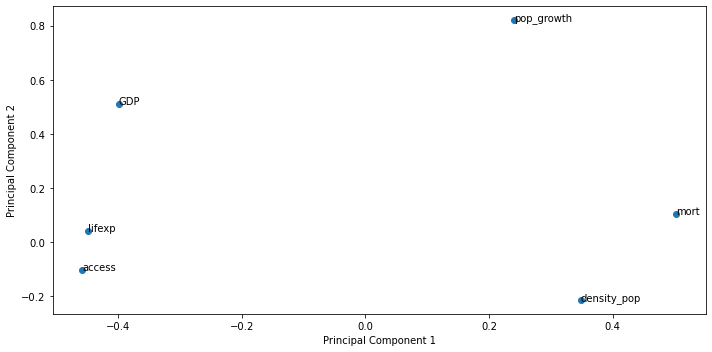

In [40]:
%matplotlib inline
fig = plt.figure(figsize = (10,5))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

### K-means clustering

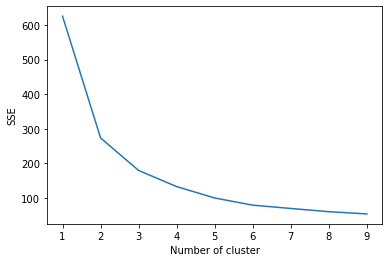

In [41]:
df_tmp_n = df_tmp2
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_tmp_n)
    df_tmp_n["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

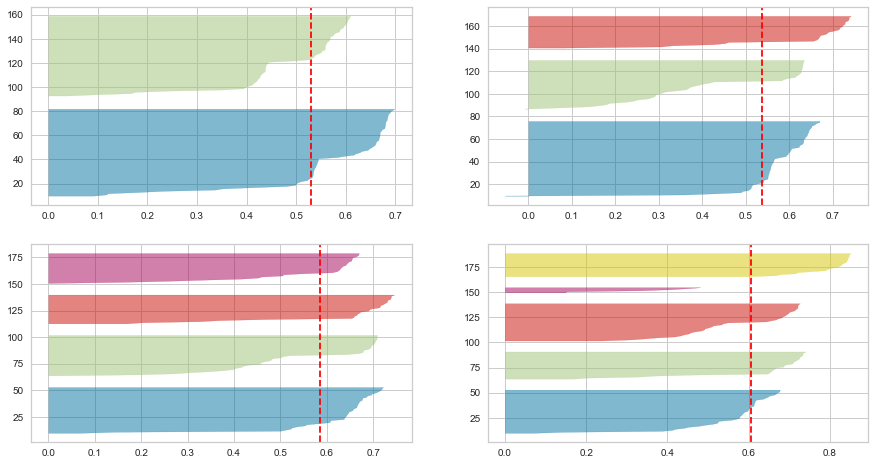

In [42]:
from yellowbrick.cluster import SilhouetteVisualizer
 
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_tmp2) 

C:\Users\Marce\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Marce\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


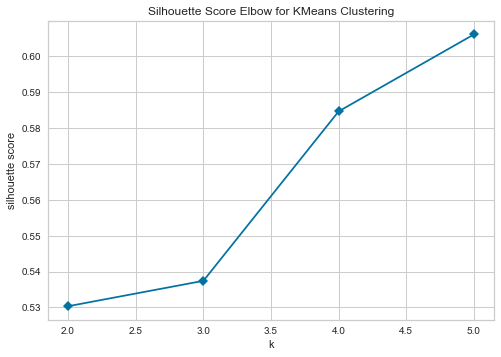

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [43]:
# Import the KElbowVisualizer method 
from yellowbrick.cluster import KElbowVisualizer

# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=42)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,6), metric='silhouette', timings=False)

# Fit the data and visualize
visualizer.fit(df_tmp_n)    
visualizer.poof()   

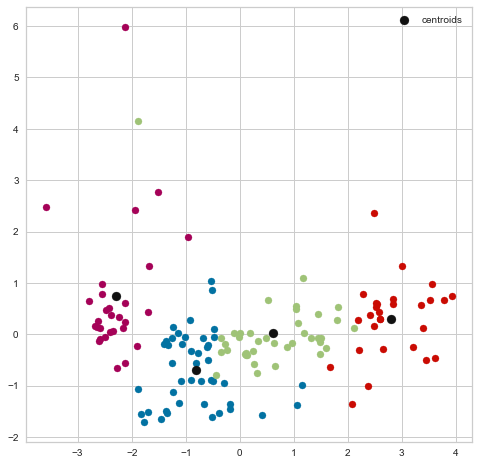

In [44]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_tmp2.values)
y_label = kmeans.predict(df_tmp2.values)
 
fix , ax = plt.subplots(1,1,figsize=(8,8))
for i in np.unique(y_label):
    idx = y_label==i
    ax.scatter(df_tmp2.values[idx,0],df_tmp2.values[idx,1])

# plotting the centroids
ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='k',s=80.0,label='centroids')
ax.legend();

### Spectral clustering

In [45]:
A = kneighbors_graph(df_tmp2.values, n_neighbors=5).toarray()
pd.DataFrame(A).sample(5)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


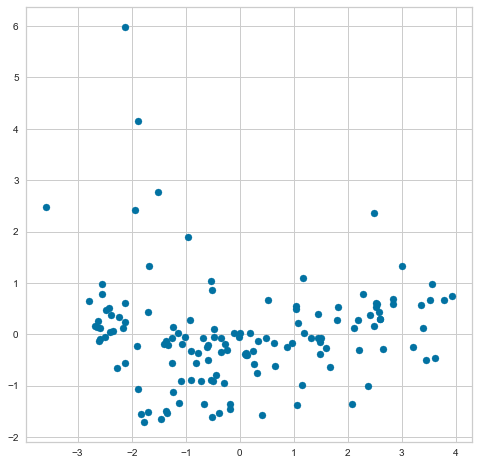

In [46]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
plt.scatter(df_tmp2['P1'], df_tmp2['P2']);

In [47]:
D = np.diag(A.sum(axis=1))
L = D-A

In [48]:
vals, vecs = np.linalg.eig(L)
vals = np.real(vals)
vecs = np.real(vecs)

In [49]:
vecs_sorted = vecs[:,np.argsort((vals))]
vals_sorted = vals[np.argsort((vals))]

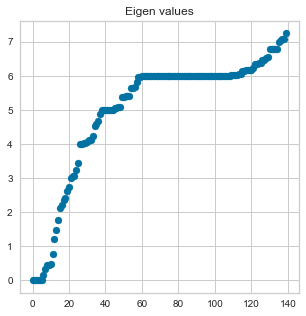

In [50]:
fig , ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(np.arange(0,len(vals_sorted)),abs(vals_sorted))
ax.set_title('Eigen values',fontsize=12);

In [51]:
U = np.array((vecs_sorted[:,1])).reshape(-1,1)

In [52]:
km = KMeans(init='k-means++', n_clusters=4, random_state=42)
km.fit(U);

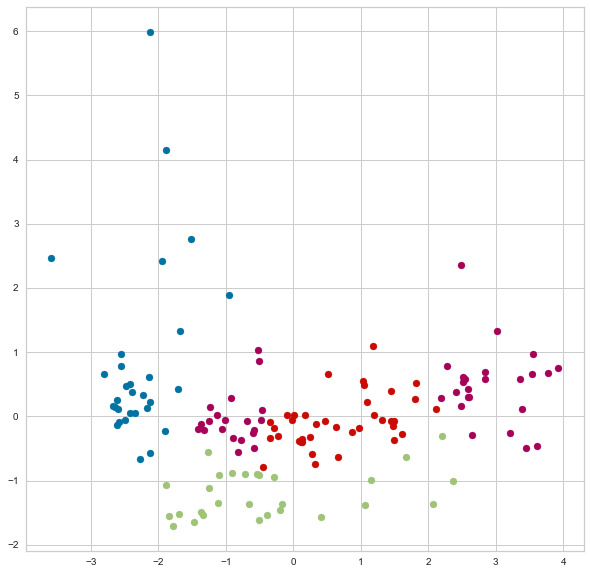

In [54]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

plt.scatter(df_tmp2.values[km.labels_==0,0],df_tmp2.values[km.labels_==0,1])
plt.scatter(df_tmp2.values[km.labels_==1,0],df_tmp2.values[km.labels_==1,1])
plt.scatter(df_tmp2.values[km.labels_==2,0],df_tmp2.values[km.labels_==2,1])
plt.scatter(df_tmp2.values[km.labels_==3,0],df_tmp2.values[km.labels_==3,1]);

Spectral Clustering v2

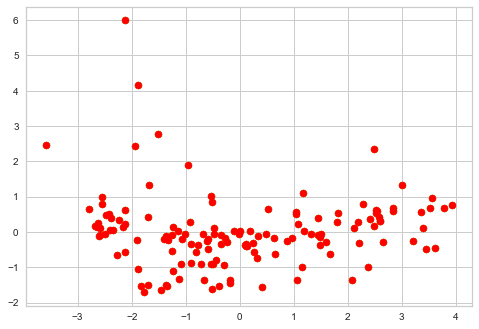

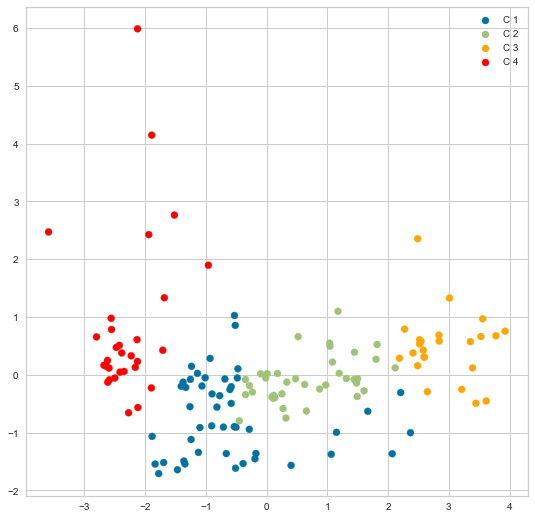

In [56]:
# Building the clustering model
spectral_model_tmp = SpectralClustering(n_clusters = 4,
                                        n_neighbors = 5,
                                       random_state=42,
                                        affinity ='rbf')
  
# Training the model and Storing the predicted cluster labels
labels_rbf =  spectral_model_tmp.fit_predict(df_tmp2)
df_tmp2['cluster_rbf'] = spectral_model_tmp.fit_predict(df_tmp2[['P1', 'P2']])
# Building the label to colour mapping
colours = {}
colours[0] = 'b'
colours[1] = 'g'
colours[2] = 'orange'
colours[3] = 'red'
# Building the colour vector for each data point
cvec = [colours[label] for label in labels_rbf]
  
# Plotting the clustered scatter plot
  
b = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='b');
y = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='g');
r = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='orange');
r1 = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='red');
plt.figure(figsize =(9, 9))
plt.scatter(df_tmp2['P1'], df_tmp2['P2'], c = cvec)
plt.legend((b, y,r,r1), ('C 1', 'C 2','C 3','C 4'))
plt.show()

C:\Users\Marce\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


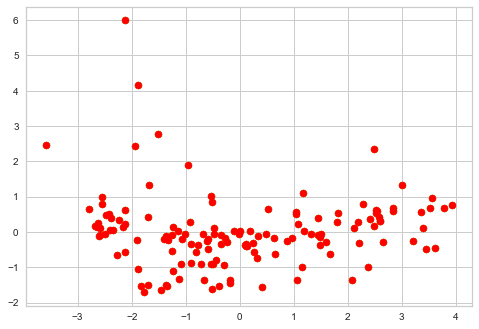

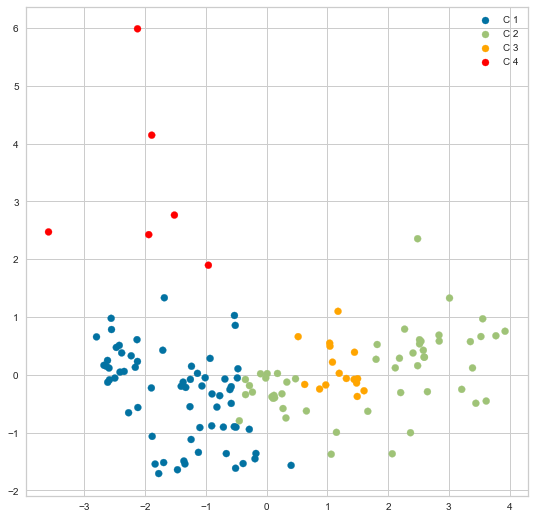

In [57]:
spec_cl = SpectralClustering(
    n_clusters=4, 
    n_neighbors=5,
    random_state=42,
    affinity='nearest_neighbors')

df_tmp2['cluster_cl'] = spec_cl.fit_predict(df_tmp2[['P1', 'P2']])

labels_nearest = spec_cl.fit_predict(df_tmp2)

# Building the label to colour mapping
colours = {}
colours[0] = 'b'
colours[1] = 'g'
colours[2] = 'orange'
colours[3] = 'red'
# Building the colour vector for each data point
cvec = [colours[label] for label in labels_nearest]
  
# Plotting the clustered scatter plot
  
b = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='b');
y = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='g');
r = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='orange');
r1 = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='red');
plt.figure(figsize =(9, 9))
plt.scatter(df_tmp2['P1'], df_tmp2['P2'], c = cvec)
plt.legend((b, y,r,r1), ('C 1', 'C 2','C 3','C 4'))
plt.show()

## Internal validation of the clusters

#### Silhoutte score

In [58]:
# Calculate Silhoutte Score

score = silhouette_score(df_tmp2, km.labels_, metric='euclidean')
score1 = silhouette_score(df_tmp2, df_tmp2.cluster_cl, metric='euclidean')
score2 = silhouette_score(df_tmp2, df_tmp2.cluster_rbf, metric='euclidean')


print('Silhouetter Score k-means: %.3f' % score)
print('Silhouetter Score spectral cluster rbf : %.3f' % score2)
print('Silhouetter Score spectral cluster: %.3f' % score1)


Silhouetter Score k-means: 0.366
Silhouetter Score spectral cluster rbf : 0.161
Silhouetter Score spectral cluster: 0.504


#### Davies-Bouldin score

In [67]:
dbs=davies_bouldin_score(df_tmp2, km.labels_)
#db3=davies_bouldin_score(df_tmp2, df_tmp2.clusters)
dbs1=davies_bouldin_score(df_tmp2, df_tmp2.cluster_rbf)
dbs2=davies_bouldin_score(df_tmp2, df_tmp2.cluster_cl)
print('davies_bouldin_score kmeans: %.3f' %  dbs)
print('davies_bouldin_score spectral cluster rbf: %.3f' % dbs1)
print('davies_bouldin_score spectral cluster: %.3f' % dbs2)

davies_bouldin_score kmeans: 1.422
davies_bouldin_score spectral cluster rbf: 0.757
davies_bouldin_score spectral cluster: 0.832


#### Calinski-Harabasz score

## Analysis of the clusters

In [60]:
df_tmp2.rename(columns= {"cluster_cl":"cluster"},inplace = True)

In [61]:
dat_tmp3 = pd.merge(df_tmp1,df_tmp2, left_index=True,right_index=True)
dat_tmp3.sample(5)

,Country,access,GDP,lifexp,mort,density_pop,pop_growth,w_stress,W_eff,P1,P2,clusters,cluster_rbf,cluster
61,IRN,0.921903,12822.50,73.75,18.75,0.429356,1.225,67.824437,4.773850,-0.896173,-0.330589,0,0,0
46,FSM,0.929443,3571.50,66.50,32.75,3.465464,0.275,0.000000,0.000000,0.404854,-1.566874,1,0,0
70,KIR,0.564715,2122.75,65.75,47.75,1.110747,1.750,0.000000,0.000000,1.441354,-0.079342,6,0,3
96,NOR,1.000000,61083.75,80.75,2.75,0.263711,0.900,0.684758,128.770322,-2.797790,0.656780,3,0,2
113,SLE,0.505270,1445.25,48.25,109.50,1.586761,2.875,0.132625,8.197602,3.926004,0.754678,4,0,1


In [62]:
Clus_GDPP=pd.DataFrame(dat_tmp3.groupby(["cluster"]).GDP.mean())
Clus_access=pd.DataFrame(dat_tmp3.groupby(["cluster"]).access.mean())
Clus_lifexp=pd.DataFrame(dat_tmp3.groupby(["cluster"]).lifexp.mean())
Clus_mort=pd.DataFrame(dat_tmp3.groupby(["cluster"]).mort.mean())
Clus_density_pop=pd.DataFrame(dat_tmp3.groupby(["cluster"]).density_pop.mean())
Clus_pop_growth=pd.DataFrame(dat_tmp3.groupby(["cluster"]).pop_growth.mean())
Clus_w_stress=pd.DataFrame(dat_tmp3.groupby(["cluster"]).w_stress.mean())
Clus_W_eff=pd.DataFrame(dat_tmp3.groupby(["cluster"]).W_eff.mean())

In [68]:
df_tmp2.cluster.value_counts()

0    47
3    35
2    30
1    28
Name: cluster, dtype: int64

In [ ]:
#dat_tmp3.describe()

In [69]:
dfclus = pd.concat([Clus_w_stress,Clus_W_eff, Clus_GDPP,
                    Clus_access,Clus_lifexp,Clus_mort,Clus_density_pop,Clus_pop_growth], axis=1)
dfclus

,w_stress,W_eff,GDP,access,lifexp,mort,density_pop,pop_growth
cluster,,,,,,,,
0,38.004084,22.420192,13010.111702,0.912909,73.260638,16.111702,0.983181,0.849468
1,9.607204,19.797836,3021.901786,0.575227,56.535714,67.375000,2.833240,2.881250
2,250.135360,144.323275,49315.575000,0.990369,79.150000,5.166667,0.229491,1.688333
3,16.209399,13.396500,5817.521429,0.780764,63.300000,40.528571,1.533893,1.745714
